<a href="https://colab.research.google.com/gist/virattt/b624560b05f50b69f1042a7a4f4adceb/sma-agent-backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U --quiet langgraph langchain_openai

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("FINANCIAL_DATASETS_API_KEY")   # For getting financial data. Get from https://financialdatasets.ai
_set_if_undefined("OPENAI_API_KEY")   # For getting financial data. Get from https://financialdatasets.ai

In [ ]:
import pandas as pd
import requests
import os
from datetime import timedelta
import matplotlib.pyplot as plt

# Import your agent's dependencies
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState

# 1. Create the Agent

In [ ]:
# Initialize the OpenAI model
gpt_4o_model = ChatOpenAI(model="gpt-4o", temperature=0)

# Update the system prompt to include portfolio management
system_prompt = """
You are a financial trading agent using a Simple Moving Average (SMA) crossover strategy with portfolio management capabilities.

Your responsibilities:
1. Analyze technical indicators (5-day and 20-day SMAs)
2. Manage portfolio allocation based on:
   - Available cash
   - Current stock position
   - Current market price
3. Generate specific trading orders with:
   - Action: 'buy', 'sell', or 'hold'
   - Quantity: number of shares to trade (must be affordable for buys or available for sells)

Base your decisions on:
- SMA crossover signals (5-day vs 20-day)
- Current portfolio state
- Risk management (don't use more than 50% of available cash in a single trade)
- Trading constraints:
  * For buy orders: ensure quantity * current_price <= available cash
  * For sell orders: ensure quantity <= current stock position

Your response should be in the format:
{
    "action": "<buy|sell|hold>",
    "quantity": <number_of_shares>
}
Only output this JSON object, without any additional text.
"""


# Update the function that calls the model
def call_agent(state: MessagesState):
    prompt = SystemMessage(content=system_prompt)
    messages = state["messages"]

    if messages and messages[0].content != system_prompt:
        messages.insert(0, prompt)

    if hasattr(messages[-1], "additional_kwargs"):
        params = messages[-1].additional_kwargs
        historical_data = get_price_data(
            params["ticker"], params["start_date"], params["end_date"]
        )
        signals = calculate_trading_signals(historical_data)
        portfolio = params.get("portfolio", {
            "cash": params.get("initial_capital", 100000),
            "stock": 0
        })

        messages[-1].content = f"""
        Current price: {signals['current_price']:.2f}
        5-day SMA: {signals['sma_5_curr']:.2f} (previous: {signals['sma_5_prev']:.2f})
        20-day SMA: {signals['sma_20_curr']:.2f} (previous: {signals['sma_20_prev']:.2f})

        Portfolio:
        Cash: ${portfolio['cash']:.2f}
        Shares: {portfolio['stock']}

        Based on the SMA crossover strategy and current portfolio, what is your trading decision?
        """

    return {"messages": [gpt_4o_model.invoke(messages)]}


# Define the agent graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_agent)
workflow.set_entry_point("agent")
app = workflow.compile()


# Update the run_agent function to include portfolio state
def run_agent(ticker: str, start_date: str, end_date: str, portfolio: dict):
    final_state = app.invoke(
        {
            "messages": [
                HumanMessage(
                    content="Make a trading decision based on the provided data.",
                    additional_kwargs={
                        "ticker": ticker,
                        "start_date": start_date,
                        "end_date": end_date,
                        "portfolio": portfolio
                    },
                )
            ]
        },
        config={"configurable": {"thread_id": 42}},
    )
    return final_state["messages"][-1].content

In [ ]:
run_agent("hello")

'hold'

# 2. Get Price Data

In [ ]:
def get_price_data(ticker, start_date, end_date):
    # Add your API key to the headers
    headers = {
        "X-API-KEY": os.environ.get("FINANCIAL_DATASETS_API_KEY")
    }

    # Create the URL
    url = (
        f'https://api.financialdatasets.ai/prices/'
        f'?ticker={ticker}'
        f'&interval=day'
        f'&interval_multiplier=1'
        f'&start_date={start_date}'
        f'&end_date={end_date}'
    )

    # Make API request
    response = requests.get(url, headers=headers)

    # Check for successful response
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code} - {response.text}")

    # Parse prices from the response
    data = response.json()
    prices = data.get('prices')
    if not prices:
        raise ValueError("No price data returned")

    # Convert prices to DataFrame
    df = pd.DataFrame(prices)

    # Convert 'time' to datetime and set as index
    df['Date'] = pd.to_datetime(df['time'])
    df.set_index('Date', inplace=True)

    # Ensure numeric data types
    numeric_cols = ['open', 'close', 'high', 'low', 'volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by date
    df.sort_index(inplace=True)

    return df


# 3. Define Trading Strategy

In [ ]:
# Define a function to calculate trading signals
def calculate_trading_signals(historical_data: pd.DataFrame) -> dict:
    """Calculate trading signals based on SMA crossover strategy"""
    # Calculate SMAs
    sma_5 = historical_data["close"].rolling(window=5).mean()
    sma_20 = historical_data["close"].rolling(window=20).mean()

    # Get the last two points of each SMA to check for crossover
    sma_5_prev, sma_5_curr = sma_5.iloc[-2:]
    sma_20_prev, sma_20_curr = sma_20.iloc[-2:]

    return {
        "current_price": historical_data["close"].iloc[-1],
        "sma_5_curr": sma_5_curr,
        "sma_5_prev": sma_5_prev,
        "sma_20_curr": sma_20_curr,
        "sma_20_prev": sma_20_prev,
    }

# 4. Create a backtester

In [ ]:
class Backtester:
    def __init__(self, agent, ticker, start_date, end_date, initial_capital):
        self.agent = agent
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.portfolio = {"cash": initial_capital, "stock": 0}
        self.portfolio_values = []

    def parse_action(self, agent_output):
        try:
            # Expect JSON output from agent
            import json
            decision = json.loads(agent_output)
            return decision["action"], decision["quantity"]
        except:
            return "hold", 0

    def execute_trade(self, action, quantity, current_price):
        """Validate and execute trades based on portfolio constraints"""
        if action == "buy" and quantity > 0:
            cost = quantity * current_price
            if cost <= self.portfolio["cash"]:
                self.portfolio["stock"] += quantity
                self.portfolio["cash"] -= cost
                return quantity
            else:
                # Calculate maximum affordable quantity
                max_quantity = self.portfolio["cash"] // current_price
                if max_quantity > 0:
                    self.portfolio["stock"] += max_quantity
                    self.portfolio["cash"] -= max_quantity * current_price
                    return max_quantity
                return 0
        elif action == "sell" and quantity > 0:
            quantity = min(quantity, self.portfolio["stock"])
            if quantity > 0:
                self.portfolio["cash"] += quantity * current_price
                self.portfolio["stock"] -= quantity
                return quantity
            return 0
        return 0

    def run_backtest(self):
        dates = pd.date_range(self.start_date, self.end_date, freq="B")

        print("\nStarting backtest...")
        print(f"{'Date':<12} {'Action':<6} {'Quantity':>8} {'Price':>8} {'Cash':>12} {'Stock':>8} {'Total Value':>12}")
        print("-" * 70)

        for current_date in dates:
            lookback_start = (current_date - timedelta(days=30)).strftime("%Y-%m-%d")
            current_date_str = current_date.strftime("%Y-%m-%d")

            agent_output = self.agent(
                ticker=self.ticker,
                start_date=lookback_start,
                end_date=current_date_str,
                portfolio=self.portfolio
            )

            action, quantity = self.parse_action(agent_output)
            df = get_price_data(self.ticker, lookback_start, current_date_str)
            current_price = df.iloc[-1]['close']

            # Execute the trade with validation
            executed_quantity = self.execute_trade(action, quantity, current_price)

            # Update total portfolio value
            total_value = self.portfolio["cash"] + self.portfolio["stock"] * current_price
            self.portfolio["portfolio_value"] = total_value

            # Log the current state with executed quantity
            print(
                f"{current_date.strftime('%Y-%m-%d'):<12} {action:<6} {executed_quantity:>8} {current_price:>8.2f} "
                f"{self.portfolio['cash']:>12.2f} {self.portfolio['stock']:>8} {total_value:>12.2f}"
            )

            # Record the portfolio value
            self.portfolio_values.append(
                {"Date": current_date, "Portfolio Value": total_value}
            )

    def analyze_performance(self):
        # Convert portfolio values to DataFrame
        performance_df = pd.DataFrame(self.portfolio_values).set_index("Date")

        # Calculate total return
        total_return = (
            self.portfolio["portfolio_value"] - self.initial_capital
        ) / self.initial_capital
        print(f"Total Return: {total_return * 100:.2f}%")

        # Plot the portfolio value over time
        performance_df["Portfolio Value"].plot(
            title="Portfolio Value Over Time", figsize=(12, 6)
        )
        plt.ylabel("Portfolio Value ($)")
        plt.xlabel("Date")
        plt.show()

        # Compute daily returns
        performance_df["Daily Return"] = performance_df["Portfolio Value"].pct_change()

        # Calculate Sharpe Ratio (assuming 252 trading days in a year)
        mean_daily_return = performance_df["Daily Return"].mean()
        std_daily_return = performance_df["Daily Return"].std()
        sharpe_ratio = (mean_daily_return / std_daily_return) * (252**0.5)
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        # Calculate Maximum Drawdown
        rolling_max = performance_df["Portfolio Value"].cummax()
        drawdown = performance_df["Portfolio Value"] / rolling_max - 1
        max_drawdown = drawdown.min()
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        return performance_df

# 4. Run the Backtest


Starting backtest...
Date         Action    Price   Shares         Cash  Total Value
------------------------------------------------------------
2024-01-09   buy      185.14      540        24.40    100000.00
2024-01-10   hold     186.19      540        24.40    100567.00
2024-01-11   buy      185.59      540        24.40    100243.00
2024-01-12   hold     185.92      540        24.40    100421.20
2024-01-16   hold     183.63      540        24.40     99184.60
2024-01-17   sell     182.68        0     98671.60     98671.60
2024-01-18   buy      188.63      523        18.11     98671.60
2024-01-19   buy      191.56      523        18.11    100203.99
2024-01-22   buy      193.89      523        18.11    101422.58
2024-01-23   buy      195.18      523        18.11    102097.25
2024-01-24   hold     194.50      523        18.11    101741.61
2024-01-25   hold     194.17      523        18.11    101569.02
2024-01-26   hold     192.42      523        18.11    100653.77
2024-01-29   sell    

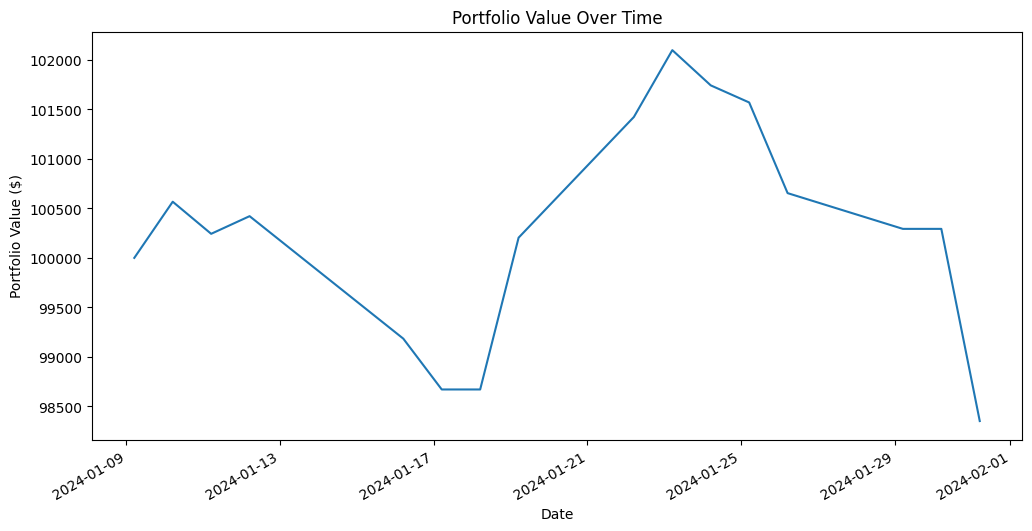

Sharpe Ratio: -1.89
Maximum Drawdown: -3.67%


In [ ]:
# Define parameters
ticker = "AAPL"  # Example ticker symbol
start_date = "2024-01-01"  # Adjust as needed
end_date = "2024-10-31"  # Adjust as needed
initial_capital = 100000  # $100,000

# Create an instance of Backtester
backtester = Backtester(
    agent=run_agent,
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
)

# Run the backtesting process
backtester.run_backtest()
performance_df = backtester.analyze_performance()